# National Climate Dynamics Workshop - Python Short Course

The remainder of this short course will introduce `pygeode`, a Python package designed for accessing, processing, and visualizing gridded geophysical data. It is an alternative to `xarray` or to `IRIS`. PyGeode uses `numpy` and `matplotlib` extensively for underlying computations and plotting, and is designed around three main principles: 

1. Data should be represented and manipulated in geophysical coordinates
2. Data should be 'lazy-loaded', i.e. left on disk until needed for computation
3. Plotting defaults should be as close to publication quality as possible

Full documentation about pygeode including a tutorial, gallery, and API reference, can be found at [pygeode.github.io](https://pygeode.github.io).

This introduction is split into three Jupyter notebooks. Each 'workbook' consists of a set of pre-written examples to introduce some of pygeode functionality, followed by a simple example to give you the chance to work with pygeode yourself.


## PyGeode Workbook #3: Processing and analysing a dataset with many NetCDF files

Large datasets are typically stored in many NetCDF files. This final workbook introduces some tools to handle this situation.

In [1]:
# C0.1 Setup matplotlib backend for inline interactive plots
%matplotlib ipympl

In [2]:
# C0.2 Import pygeode, numpy, and matplotlib plotting packages
import pygeode as pyg
import numpy as np
from matplotlib import pyplot as plt

### 1. Opening multiple files at once

There are two main tools for opening datasets comprised of multiple files.

The first, `openall()`, opens up each file in the list provided (this can be in the form of an explicit python list, a wildcard expression, or a mix of the two). It then concatenates all the variables found according to the coordinate data it finds.

In [3]:
#C1.1 Open files using openall()

# Set this path to wherever you've stored the sample data provided.
data_pth = './data/'

# Open all netcdf files in given path
ds1 = pyg.openall(data_pth + '*/*.nc')
print(ds1)

<Dataset>:
Vars:
  t (time,latitude,longitude)  (3652,72,72)
  u (time,latitude,longitude)  (3652,72,72)
  v (time,latitude,longitude)  (3652,72,72)
Axes:
  time <StandardTime>:  Jan 1, 2010 00:00:00 to Dec 31, 2019 00:00:00 (3652 values)
  latitude <Lat> :  90 S to 88 N (72 values)
  longitude <Lon>:  0 E to 355 E (72 values)
Global Attributes:
  Conventions    : CF-1.0


We are left with a single dataset consisting of temperature and horizontal wind data at 800 hPa from ERA5. The same `dimtypes` and `namemap` options that were available when opening single files are still available here if you need to tweak anything.

This has the advantage of being very simple and reasonably flexible. The disadvantage is that for larger datasets (comprised of many hundreds or thousands of files), even just reading the metadata from each file can be a time consuming process.

For these cases, a second option is avaible. `open_multi()` also takes a list of files, but it only reads the metadata from the first file, and assumes that the rest of the files contain the same variables defined on the same spatial grid, but defined over a different time period. It then infers the contents of the rest of the files based on their filenames.

In [4]:
#1.2 Open files using open_multi()

dss = []

# Open all netcdf files containing each variable independently    
for v in ['t', 'u', 'v']:
    # The pattern argument provides a means of translating from filenames to dates
    ds = pyg.open_multi(data_pth + '*/*_%s.nc' % v, pattern='$Y$m')
    dss.append(ds)

# Concatenate the three datasets
ds2 = pyg.concatenate(dss)
print(ds2)

<Dataset>:
Vars:
  t (time,latitude,longitude)  (3652,72,72)
  u (time,latitude,longitude)  (3652,72,72)
  v (time,latitude,longitude)  (3652,72,72)
Axes:
  time <StandardTime>:  Jan 1, 2010 00:00:00 to Dec 31, 2019 00:00:00 (3652 values)
  latitude <Lat> :  88 N to 90 S (72 values)
  longitude <Lon>:  0 E to 355 E (72 values)
Global Attributes:
  Conventions    : CF-1.0


This is less flexible than `openall()`, but much faster to open and to manipulate, especially for larger datasets. 

In [8]:
#1.3 Time loading a single variable for this dataset from openall()
%timeit -n 1 -r 1 ds1.t.mean('time').load()

1.52 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
#1.4 Time loading a single variable for this dataset from open_multi()
%timeit -n 1 -r 1 ds2.u.mean('time').load()

1.92 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### 2. Computing climatologies and saving netcdf files

Now that we have 10 years of data available to us, we can compute some climatologies. Since computing them can take a bit of time, we'll see how to save the results to disk so that we don't have to recompute them. We want to compute the climatology of each field (temperature, u, v) in the dataset, so we'll also illustrate the use `Dataset.map()`, which applies a given function to each variable in a dataset.

In [10]:
#2.1 Compute climatology for each variable

# To deal with leap years, the following function removes a single day
# from each leap year to end up with a uniform 365-day year
def remleap(v):
    return pyg.timeutils.removeleapyears(v, omitdoy_leap=[182]).rename(v.name)

# This computes the climatology
def clim(v):
    return pyg.climatology(v).rename(v.name)

# Apply each operation to the dataset
dsnl = ds2.map(remleap)
dsc = dsnl.map(clim)

print(dsc)

<Dataset>:
Vars:
  t (time,latitude,longitude)  (365,72,72)
  u (time,latitude,longitude)  (365,72,72)
  v (time,latitude,longitude)  (365,72,72)
Axes:
  time <ModelTime365>:  Jan 1,  00:00:00 to Dec 31,  00:00:00 (365 values)
  latitude <Lat> :  88 N to 90 S (72 values)
  longitude <Lon>:  0 E to 355 E (72 values)
Global Attributes:
  Conventions    : CF-1.0


We now have variables defined on a 365-day calendar year, but note one further thing: the dates do not have a year associated with them. This signals to PyGeode that this is a climatology. This will be useful when we start to compute anomalies below.

This operation completes quickly because once again, PyGeode has not actually done any computations. We are going to want these climatologies though, so we'll go ahead and save them to disk.

In [11]:
#C2.2 Save climatology to disk if it doesn't exist

# We'll save this climatology in the same directory as the sample data
# Change cl_path if you would like to save it somewhere else
cl_file = 'e5_800hPa_clim.nc'
cl_pth = data_pth + cl_file

import os
# Check first if the file exists already; if so, no need to recompute.
if not os.path.exists(cl_pth):
    pyg.save(cl_pth, dsc)

# Use saved climatology in either case
dsc = pyg.open(cl_pth)

With only 10 years of data, the climatology of daily data is still quite noisy. We can apply a smoothing operator to retain only the first few harmonics of the seasonal cycle.

In [12]:
print(dsc)

<Dataset>:
Vars:
  t (time,latitude,longitude)  (1460,181,360)
  u (time,latitude,longitude)  (1460,181,360)
  v (time,latitude,longitude)  (1460,181,360)
Axes:
  time <ModelTime365>:  Jan 1,  00:00:00 to Dec 31,  18:00:00 (1460 values)
  latitude <Lat> :  90 N to 90 S (181 values)
  longitude <Lon>:  0 E to 359 E (360 values)
Global Attributes:
  Conventions    : CF-1.0


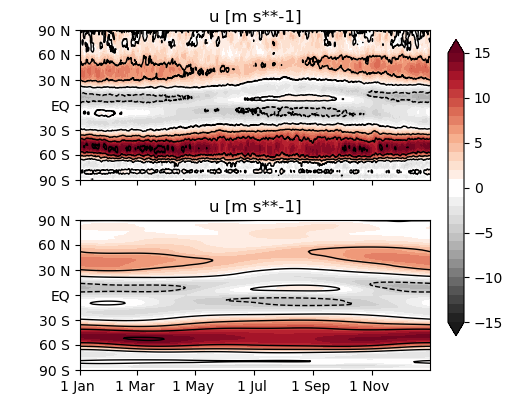

In [13]:
#C2.3 Plot smoothed versus un-smoothed climatology

# Compute the zonal mean zonal wind
uz = dsc.u.mean('lon')

# Apply smoothing operator; retain up to 4th harmonic
us = uz.fft_smooth('time', 4)

# We can use showgrid() to compare the two
pyg.showgrid([uz, us], style='div', ncol=1, cdelt=5., nf=5, ndiv=3, nl=1, cmap=plt.cm.RdGy_r, extend='both')

### 3. Computing anomalies and run a simple statistical test

We are now set up to work with the climatologies. We'll use them to compute anomalous winds and the transient eddy kinetic energy at this level.

In [15]:
#C3.1 Compute transient eddy kinetic energy 

#Smooth climatologies 
uc = dsc.u.fft_smooth('time', 4)
vc = dsc.v.fft_smooth('time', 4)

# Pygeode automatically broadcasts climatologies so that the following works as expected:
up = dsnl.u - dsc.u
vp = dsnl.v - dsc.v

# Compute EKE
eke = 0.5 * (up**2 + vp**2)
eke = eke.rename("EKE")

# The following adds a duplicate longitude so that global plots with
# Cartopy don't have a missing gap
eke = pyg.rotatelon(eke, origin=0, duplicate = True)

# Compute DJF and JJA means
eke_djf = eke(l_month = [12, 1, 2]).load()
eke_jja = eke(l_month = [6,  7, 8]).load()

Loading <Var 'EKE'>:          100%|#############################|Time:  0:01:45
Loading <Var 'EKE'>:          100%|#############################|Time:  0:01:54


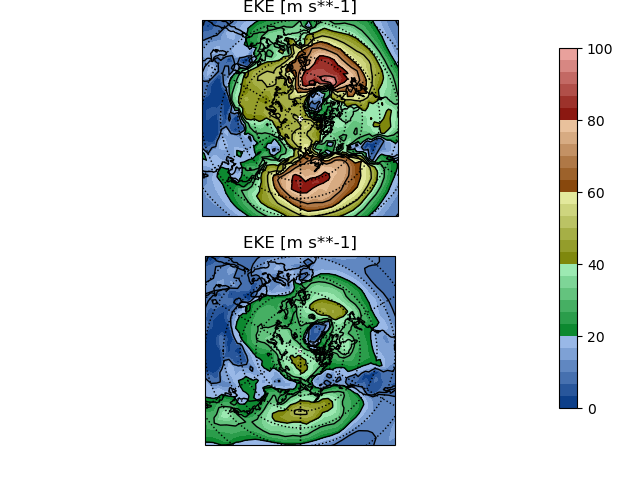

In [16]:
#C3.2 Plot DJF and JJA EKE

fig = plt.figure()

plt.ioff()

from cartopy import crs as ccrs
npst = ccrs.Stereographic(central_longitude=180, central_latitude=90)

ax = pyg.showgrid([eke_djf.mean('time'), eke_jja.mean('time')], ncol=1, size = (4, 4), map=dict(projection=npst))

ax.axes[0].axes[0].set_extent([0, 359, 30, 90], crs = ccrs.PlateCarree())
ax.axes[0].axes[1].set_extent([0, 359, 30, 90], crs = ccrs.PlateCarree())
ax.render(fig=fig)
plt.ion()

plt.show()

In [17]:
#C3.3 Compute correlation between u' and v'
up_djf = up(l_month = [12,1,2]).load()
vp_djf = vp(l_month = [12,1,2]).load()

d = pyg.correlate(up_djf, vp_djf, ['time'], output='r,r2,p')

# Adjust p-value for field significance following Wilks (2016)
pi = d.p[:].ravel()
pi = np.sort(pi)
isig = np.where(pi < np.linspace(0, 0.01, len(pi)))[0] 
if len(isig) > 0:
    pt = pi[isig[-1]]

sigmask = (1 - 0.5*d.p) * pyg.sign(d.r)

Loading <Var '(u-u)'>:        100%|#############################|Time:  0:00:50
Loading <Var '(v-v)'>:        100%|#############################|Time:  0:00:48
/data/aether/adk33/mamba/envs/mpy3/lib/python3.11/site-packages/pygeode-1.4.0a1-py3.11-linux-x86_64.egg/pygeode/stats.py:168: UserWarning: r2 now returns the correct value as opposed to r
  warn ("r2 now returns the correct value as opposed to r")


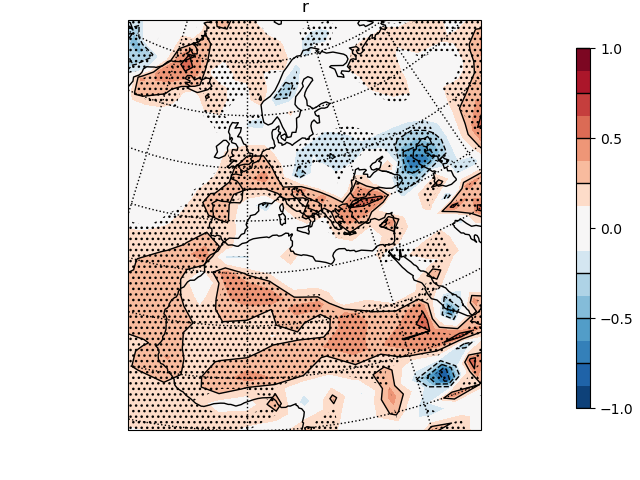

In [18]:
# C3.4 Plot result, including a significance mask
fig = plt.figure()
plt.ioff()

from cartopy import crs as ccrs

cr = pyg.clfdict(0.5, ndiv=2, nf = 4, style='div', nozero=True, cmap = plt.cm.RdBu_r)

r = pyg.rotatelon(d.r, origin=-180)
sm = pyg.rotatelon(sigmask, origin=-180)

ax = pyg.showvar(r, map=dict(projection='EquidistantConic'), **cr)
pyg.vsigmask(sm, axes=ax.axes[0], mjsig = 1 - pt)

ax.axes[0].set_extent([-20, 40, 0, 75], crs = ccrs.PlateCarree())
ax.render(fig=fig)
plt.ion()

plt.show()

## Exercise:
Compute climatology of meridional heat flux (v'T'), plot time series.